In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# from embed import Embedding

In [2]:
# embed_file = 'sgns.sogou.word'
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
device = torch.device("cuda")

EMBED_DIM = 300

def is_valid(seg):
    for w in seg:
        if not ('\u4e00' <= w and w <= '\u9fff'):
            return False
    return True


class Embed:
    def __init__(self, file_path='../data/sgns.sogou.word'):
        self.idx_seg = ['unk']
        self.seg_idx = {'unk': 0}
        self.idx_emb = [[0.0 for i in range(EMBED_DIM)]]
        
        with open(file_path, 'r') as f:
            for idx, line in enumerate(f.readlines(), start=1):
                emb = line.split()[1:]
                seg = line.split()[0]
                # print(emb, seg)
                if is_valid(seg) and (seg not in self.seg_idx):
                    self.idx_seg.append(seg)
                    self.seg_idx[seg] = idx
                    self.idx_emb.append([float(i) for i in emb])
    def embed(self, seg):
        if seg in self.seg_idx:
            return self.seg_idx[seg]
        else:
            return self.seg_idx['unk']

In [3]:
VOCAB_SIZE = 364182


class TextCNN(nn.Module):
    def __init__(self, channel_out=16, kernel_size=[2,3,4], dropout=0.5, pretrained_embed=Embed().idx_emb):
        super(TextCNN, self).__init__()
        channel_in = 1
        self.classes = 8
        self.embed_dim = 300
        self.embed = nn.Embedding(VOCAB_SIZE, self.embed_dim)
        # self.embed.weight.data.copy_(torch.from_numpy(np.array(pretrained_embed)))
        
        self.conv1 = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=(kernel_size[0], self.embed_dim))
        self.conv2 = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=(kernel_size[1], self.embed_dim))
        self.conv3 = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=(kernel_size[2], self.embed_dim))
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(kernel_size) * channel_out, 64)
        self.fc2 = nn.Linear(64, self.classes)
    
    def forward(self, x):
        x = x.to(device)
        x = self.embed(x)
        x = x.unsqueeze(1)

        x1=self.conv1(x)
        x1=F.relu(x1.squeeze(3))
        x1=F.max_pool1d(x1,x1.size(2)).squeeze(2)

        x2=self.conv2(x)
        x2=F.relu(x2.squeeze(3))
        x2=F.max_pool1d(x2,x2.size(2)).squeeze(2)

        x3=self.conv3(x)
        x3=F.relu(x3.squeeze(3))
        x3=F.max_pool1d(x3,x3.size(2)).squeeze(2)

        x=torch.cat((x1,x2,x3),1)
        x=self.dropout(x)

        x=self.fc1(x)
        x=F.relu(x)
        logit=self.fc2(x)
        return logit

In [4]:
# model(torch.LongTensor([1,1,11,] * 400))

In [5]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import json
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import f1_score
import random


weightFile='./pkl/weight'
train_file='../data/train_dic.json'
test_file='../data/test_dic.json'
# change a line
# test_file='../data/modify_test_dic.json'


with open(train_file,'r') as f:
    train_dic = json.load(f)
with open(test_file,'r') as f:
    test_dic=json.load(f)


class trainset(Dataset):
    def __init__(self):
        self.textdata=torch.LongTensor(train_dic['indexed_text'])
        self.labeldata=torch.LongTensor(train_dic['emo'])

    def __len__(self):
        return len(self.textdata)

    def __getitem__(self,index):
        return self.textdata[index],self.labeldata[index]

class testset(Dataset):
    def __init__(self):
        self.textdata=torch.LongTensor(test_dic['indexed_text'])
        self.labeldata=torch.LongTensor(test_dic['emo'])
        # add 1 line
        # self.distridata=torch.LongTensor(test_dic['label'])

    def __len__(self):
        return len(self.textdata)

    def __getitem__(self,index):
        return self.textdata[index],self.labeldata[index]
        # replace a line
        # return self.textdata[index],self.distridata[index]

In [6]:
BATCH_SIZE=64
lr=5e-4
train_len=len(train_dic['label'])
train_size = 2342
test_size = 2228

trainset = trainset()
trainloader = DataLoader(dataset=trainset,batch_size=BATCH_SIZE,shuffle=True)
testset = testset()
testloader = DataLoader(dataset=testset,batch_size=BATCH_SIZE,shuffle=False)


In [7]:
train_loss_list = list()
train_ratio_list = list()
test_loss_list = list()
test_ratio_list = list()

train_macro_list = list()
train_micro_list = list()
train_coef_list = list()
test_macro_list = list()
test_micro_list = list()
test_coef_list = list()


model = TextCNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()


EPOCH = 300
for i in range(EPOCH):
    model.train()
    train_loss = 0
    batchnum = 0
    for text,label in trainloader:
        text, label = text.to(device), label.to(device)
        batchnum +=1
        optimizer.zero_grad()
        out = model(text)
        loss = loss_fn(out,label)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= batchnum
    print('Epoch: %d,  train_loss: %.8f' % (i, train_loss), end='\t')
    train_loss_list.append(train_loss)
    # if epoch % 10 == 0:
        # torch.save(model.state_dict(), weightFile+str(epoch)+'.pkl_test')
        
    model.eval()
    correct = 0
    total = 0
    coef = 0
    ground = list()
    pred = list()

    with torch.no_grad():
        model.eval()
        for text,label in trainloader:
            text, label = text.to(device), label.to(device)
            out = model(text)
            for ind in range(len(out)):
                v0 = test_dic['label'][ind][1:]
                ol = []
                for i in range(len(out[ind])):
                    ol.append(float(out[ind][i]))
                c = pearsonr(ol,v0)
                coef += c[0]
            prediction = torch.argmax(out, 1)
            ground.append(label)
            pred.append(prediction)
            # lc.append(prediction)
            correct += (prediction == label).sum().float()
            total += len(label)
        # lc = np.array(lc)
        # v = np.array(test_dic['emo'])
        print('Acc_train: %.5f,  Coef_train: %.5f' % (correct.item() / total, coef / total), end='\t')
        train_ratio_list.append(correct.item() / total)
        train_coef_list.append(coef / total)

        macro_tot = 0
        micro_tot = 0
        for i, j in zip(ground, pred):
            macro_tot += f1_score(i.cpu().numpy(),j.cpu().numpy(),average='macro')
            micro_tot += f1_score(i.cpu().numpy(),j.cpu().numpy(),average='micro')
        # print('f1_score_macro: %.5f,\t f1_score_micro: %.5f' % (macro_tot / len(pred), micro_tot / len(pred)))
        train_macro_list.append(macro_tot / len(pred))
        train_micro_list.append(micro_tot / len(pred))
        
        
    model.eval()
    correct = 0
    total = 0
    coef = 0
    ground = list()
    pred = list()

    with torch.no_grad():
        model.eval()
        for text,label in testloader:
            text, label = text.to(device), label.to(device)
            out = model(text)
            for ind in range(len(out)):
                v0 = test_dic['label'][ind][1:]
                ol = []
                for i in range(len(out[ind])):
                    ol.append(float(out[ind][i]))
                c = pearsonr(ol,v0)
                coef += c[0]
            prediction = torch.argmax(out, 1)
            ground.append(label)
            pred.append(prediction)
            correct += (prediction == label).sum().float()
            total += len(label)
        print('Acc_test: %.5f,  Coef_test: %.5f' % (correct.item() / total, coef / total), end='\n')
        test_ratio_list.append(correct.item() / total)

        macro_tot = 0
        micro_tot = 0
        for i, j in zip(ground, pred):
            macro_tot += f1_score(i.cpu().numpy(),j.cpu().numpy(),average='macro')
            micro_tot += f1_score(i.cpu().numpy(),j.cpu().numpy(),average='micro')
        # print('f1_score_macro: %.5f,\t f1_score_micro: %.5f' % (macro_tot / len(pred), micro_tot / len(pred)))
        test_macro_list.append(macro_tot / len(pred))
        test_micro_list.append(micro_tot / len(pred))

Epoch: 0,  train_loss: 1.78807040	Acc_train: 0.42015,  Coef_train: 0.36935	Acc_test: 0.47756,  Coef_test: 0.37007
Epoch: 1,  train_loss: 1.68924784	Acc_train: 0.42015,  Coef_train: 0.36764	Acc_test: 0.47756,  Coef_test: 0.36818
Epoch: 2,  train_loss: 1.64103217	Acc_train: 0.42015,  Coef_train: 0.37294	Acc_test: 0.47756,  Coef_test: 0.37446
Epoch: 3,  train_loss: 1.62024367	Acc_train: 0.42101,  Coef_train: 0.36797	Acc_test: 0.47756,  Coef_test: 0.37217
Epoch: 4,  train_loss: 1.59969265	Acc_train: 0.48634,  Coef_train: 0.36073	Acc_test: 0.51750,  Coef_test: 0.36725
Epoch: 5,  train_loss: 1.57195846	Acc_train: 0.50299,  Coef_train: 0.36142	Acc_test: 0.52828,  Coef_test: 0.36967
Epoch: 6,  train_loss: 1.55504301	Acc_train: 0.51110,  Coef_train: 0.35625	Acc_test: 0.52783,  Coef_test: 0.36518
Epoch: 7,  train_loss: 1.52790570	Acc_train: 0.55081,  Coef_train: 0.33700	Acc_test: 0.56149,  Coef_test: 0.35323
Epoch: 8,  train_loss: 1.50612344	Acc_train: 0.54398,  Coef_train: 0.35015	Acc_test: 0.5

Epoch: 142,  train_loss: 0.10447039	Acc_train: 0.99829,  Coef_train: 0.13831	Acc_test: 0.48878,  Coef_test: 0.21808
Epoch: 143,  train_loss: 0.10109471	Acc_train: 0.99872,  Coef_train: 0.14875	Acc_test: 0.50494,  Coef_test: 0.22953
Epoch: 144,  train_loss: 0.11914109	Acc_train: 0.99872,  Coef_train: 0.15234	Acc_test: 0.49776,  Coef_test: 0.23024
Epoch: 145,  train_loss: 0.10843899	Acc_train: 0.99872,  Coef_train: 0.13575	Acc_test: 0.50045,  Coef_test: 0.21819
Epoch: 146,  train_loss: 0.10739298	Acc_train: 0.99829,  Coef_train: 0.15313	Acc_test: 0.49551,  Coef_test: 0.22629
Epoch: 147,  train_loss: 0.10354943	Acc_train: 0.99915,  Coef_train: 0.14972	Acc_test: 0.49327,  Coef_test: 0.23323
Epoch: 148,  train_loss: 0.10754313	Acc_train: 0.99872,  Coef_train: 0.16334	Acc_test: 0.50359,  Coef_test: 0.23779
Epoch: 149,  train_loss: 0.09492476	Acc_train: 0.99872,  Coef_train: 0.15054	Acc_test: 0.50180,  Coef_test: 0.23191
Epoch: 150,  train_loss: 0.09748219	Acc_train: 0.99829,  Coef_train: 0.1

Epoch: 282,  train_loss: 0.06049896	Acc_train: 0.99915,  Coef_train: 0.18095	Acc_test: 0.49013,  Coef_test: 0.24723
Epoch: 283,  train_loss: 0.06975174	Acc_train: 0.99957,  Coef_train: 0.18800	Acc_test: 0.48833,  Coef_test: 0.25274
Epoch: 284,  train_loss: 0.06166404	Acc_train: 0.99915,  Coef_train: 0.18306	Acc_test: 0.49686,  Coef_test: 0.25272
Epoch: 285,  train_loss: 0.05732338	Acc_train: 0.99915,  Coef_train: 0.18086	Acc_test: 0.48968,  Coef_test: 0.24404
Epoch: 286,  train_loss: 0.06939092	Acc_train: 0.99915,  Coef_train: 0.17841	Acc_test: 0.49596,  Coef_test: 0.24489
Epoch: 287,  train_loss: 0.06402444	Acc_train: 0.99915,  Coef_train: 0.17420	Acc_test: 0.49057,  Coef_test: 0.23675
Epoch: 288,  train_loss: 0.06383135	Acc_train: 0.99915,  Coef_train: 0.16838	Acc_test: 0.49910,  Coef_test: 0.24323
Epoch: 289,  train_loss: 0.04767327	Acc_train: 0.99957,  Coef_train: 0.18931	Acc_test: 0.50404,  Coef_test: 0.24946
Epoch: 290,  train_loss: 0.05276655	Acc_train: 0.99957,  Coef_train: 0.1

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def paint(name, color='blue'):
    vals = eval(name + '_list')
    leng = len(vals)
    x_axis = list(range(len(vals)))
    plt.figure(figsize=(12.8, 9.6))
    plt.xlim(0, np.max(x_axis) * 1.1)
    plt.ylim(0, np.max(vals) * 1.1)
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.text(x=np.max(x_axis) * 0.3, y=np.max(vals) * 0.9, s=name + '_curve', fontsize=20)
    plt.plot(x_axis, vals, label=name, color=color)
    # plt.plot(x_axis, test_ratio_list, label='test_loss')
    plt.legend()
    plt.savefig('cnn_{}{}_channel16.png'.format(name, leng))

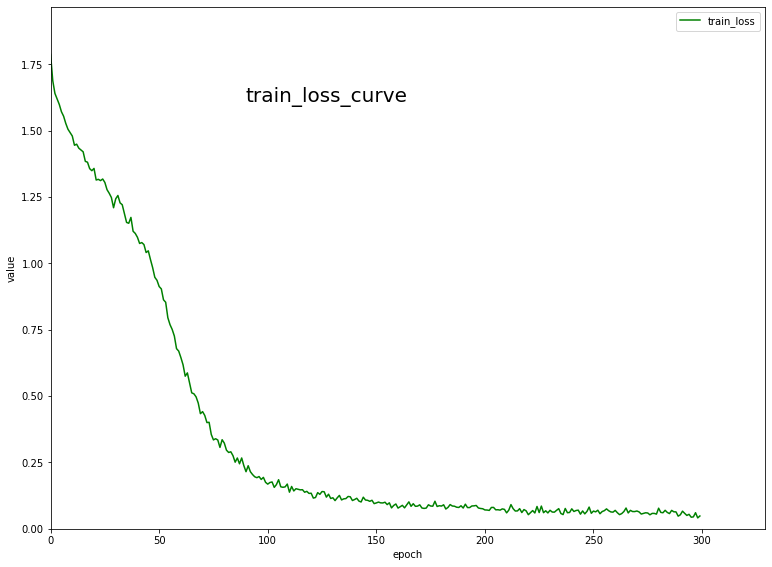

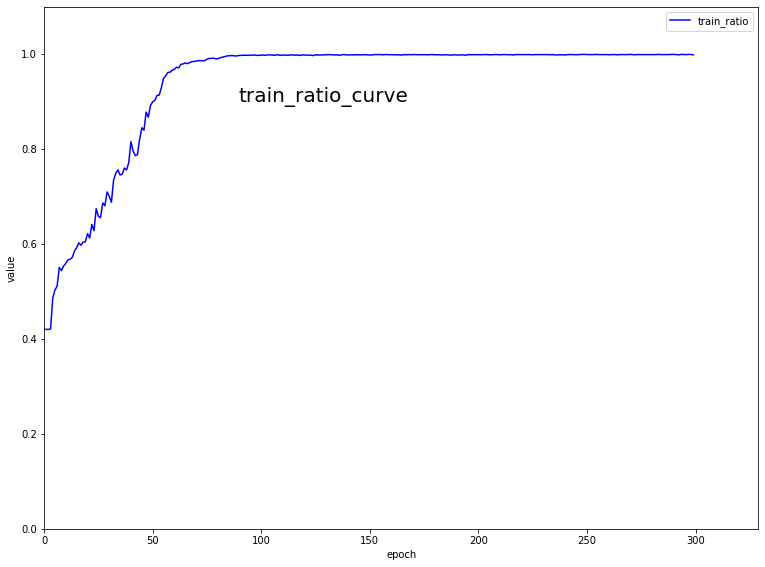

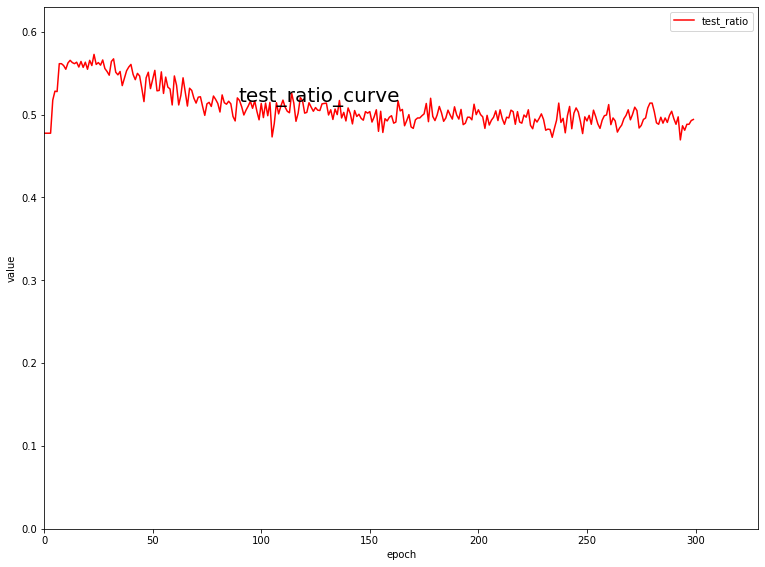

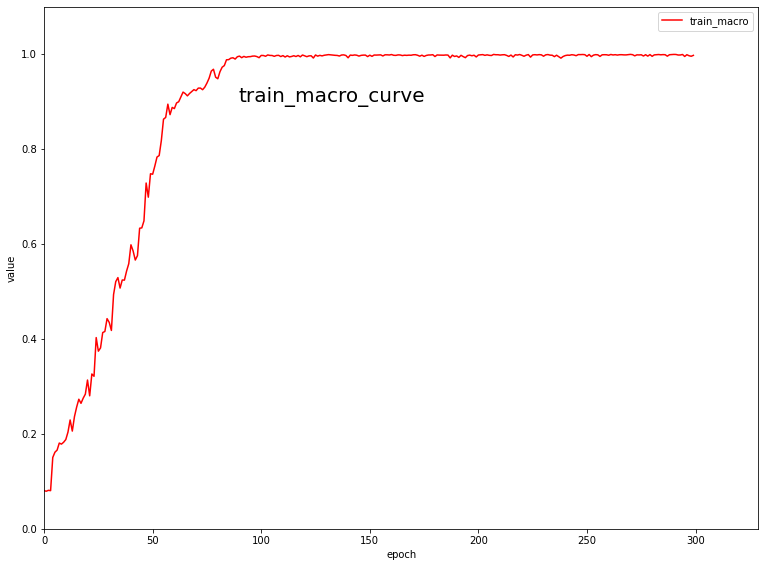

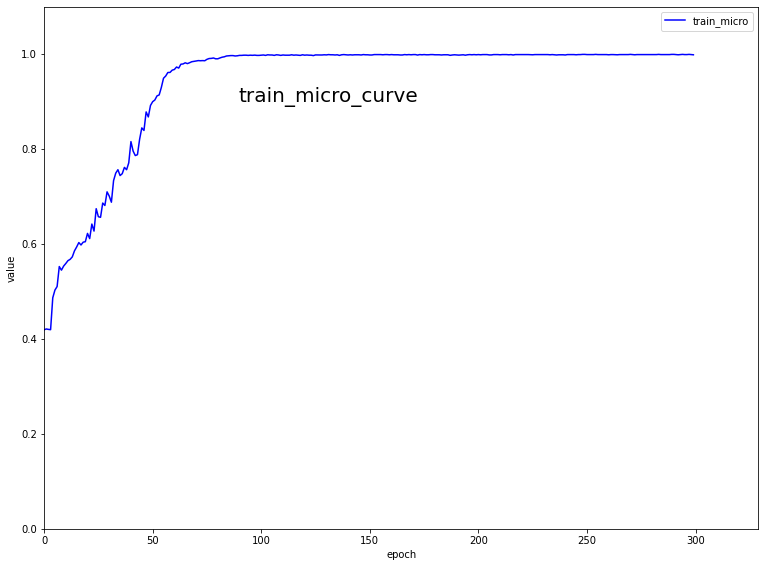

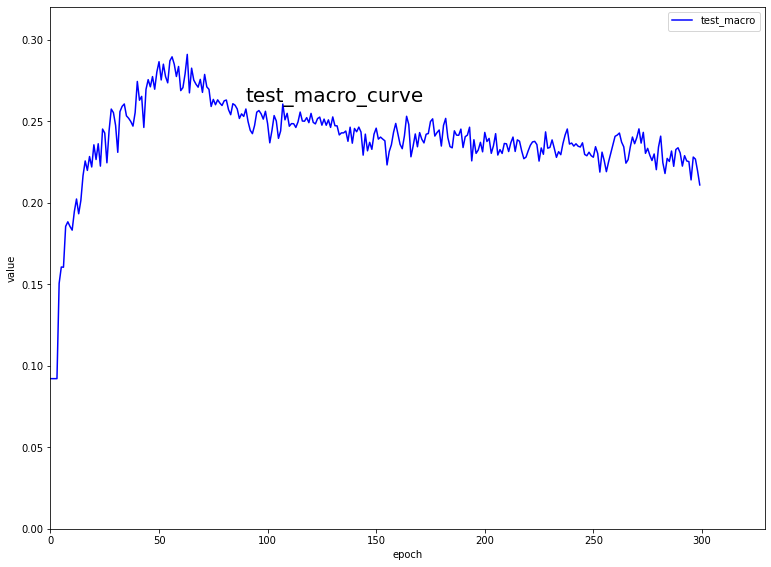

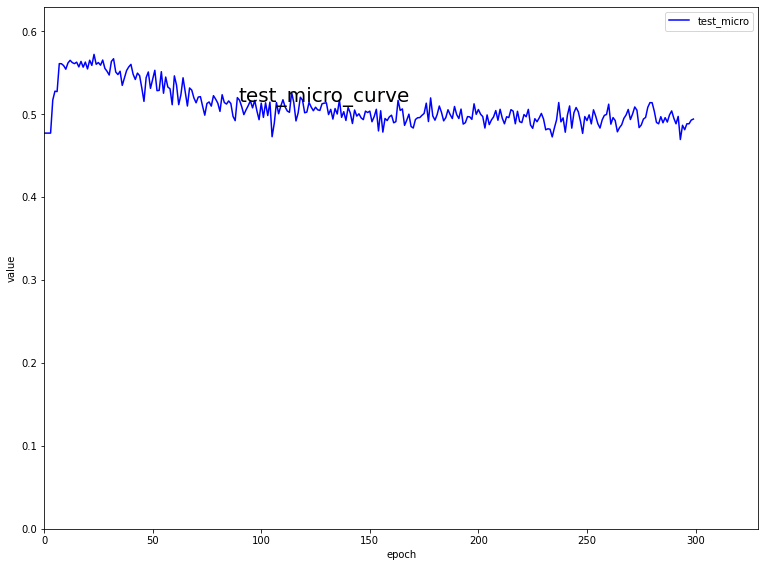

In [13]:
paint('train_loss', 'green')
paint('train_ratio', 'blue')

# paint('test_loss')
paint('test_ratio', 'red')

paint('train_macro', 'red')
paint('train_micro', 'blue')
paint('test_macro')
paint('test_micro')

In [14]:
import json
json.dump([train_loss_list, train_ratio_list, test_loss_list, test_ratio_list, train_macro_list, train_micro_list, test_macro_list, test_micro_list], open('16.json', 'w'))

In [ ]:
# TESTING
os.environ["CUDA_VISIBLE_DEVICES"] = '5'
device = torch.device("cuda")

test = validset()
testloader = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False)
testmodel = TextCNN()
# opt=torch.optim.Adam(testmodel.parameters(),lr=LR)

correct = 0
total = 0
epoch = 8
coef = 0


ground = list()
pred = list()

with torch.no_grad():
    epo = 10
    testmodel.load_state_dict(torch.load(weightFile+str(epo)+'.pkl_test'))
    testmodel = testmodel.to(device)
    testmodel.eval()
    for text, label in testloader:
        text, label = text.to(device), label.to(device)
        out = testmodel(text)
        for ind in range(len(out)):
            v0 = test_dic['label'][ind][1:]
            out_list = []
            for i in range(len(out[ind])):
                out_list.append(float(out[ind][i]))
            c = pearsonr(out_list, v0)
            coef += c[0]
        prediction = torch.argmax(out, 1)
        ground.append(label)
        pred.append(prediction)
        correct += (prediction == label).sum().float()
        total += len(label)
    v = np.array(test_dic['emo'])
    print('Epoch No.' + str(epo))
    print('correct cnt:', correct)
    print('total cnt:', total)
    print('acc:', correct.item()/total)
    print('Coef:', coef/total)

    macro_tot = 0
    micro_tot = 0
    cnt = 0
    for i, j in zip(ground, pred):
        macro_tot += f1_score(i.cpu().numpy(),
                              j.cpu().numpy(), average='macro')
        micro_tot += f1_score(i.cpu().numpy(),
                              j.cpu().numpy(), average='micro')
        cnt += 1
    print('f_score macro_ave:', macro_tot / cnt)
    print('f_score micro_ave:', micro_tot / cnt)

# Epoch No.0
# correct cnt: tensor(1064., device='cuda:0')
# total cnt: 2228
# acc: 0.47755834829443444
# Coef: 0.37362037831079
# f_score macro_ave: 0.08616564807687764
# f_score micro_ave: 0.47576121794871795

# Epoch No.10
# correct cnt: tensor(1304., device='cuda:0')
# total cnt: 2228
# acc: 0.585278276481149
# Coef: 0.3280711656819389
# f_score macro_ave: 0.22395226841789884
# f_score micro_ave: 0.5837339743589743

In [ ]:
# coef
coef_file='../data/modify_test_dic.json'

with open(coef_file,'r') as f:
    coef_dic=json.load(f)

class coefset(Dataset):
    def __init__(self):
        self.textdata=torch.LongTensor(coef_dic['indexed_text'])
        self.labeldata=torch.FloatTensor(coef_dic['label'])

    def __len__(self):
        return len(self.textdata)

    def __getitem__(self,index):
        return self.textdata[index], self.labeldata[index]


coefset = coefset()
coefloader = DataLoader(dataset=coefset,batch_size=BATCH_SIZE,shuffle=False)
coefmodel = TextCNN()


correct=0
total=0
epoch=8
coef=0

ground = list()
pred = list()


epo = 150
coefmodel.load_state_dict(torch.load(weightFile+str(epo - 1)+'.pkl3'))
coefmodel = coefmodel.to(device)
tot_coef = 0
# macro_tot = 0
for batch_num, (text,label) in enumerate(coefloader):
    coefmodel.eval()
    text, label = text.to(device), label.to(device)
    out=coefmodel(text)
    local_macro = 0
    local_coef = 0
    for i, j in zip(out.data.cpu().numpy(), label.data.cpu().numpy()):
        local_coef += pearsonr(i, j)[0]
        # local_macro += f1_score(i,j,average='macro')
    local_coef /= len(out)
    # local_macro /= len(out)
    tot_coef += local_coef
    # macro_tot ++ local_macro

print('tot_coef:', tot_coef / batch_num)

In [ ]:
# f1_score([1,0,0], [0,1,0], 'micro')

In [ ]:
for cnt, (text, label) in enumerate(testloader):
    if cnt == 2:
        break
    text, label = text.to(device), label.to(device)
    print(text.shape)
    print(label)
    print('res:', testmodel(text))
    # print(f1_score())
    
for (i, j) in zip(testmodel(text).data.cpu().numpy(), label.data.cpu().numpy()):
    # print(i)
    print(j)

In [ ]:
# EPOCH 100
# f_score macro_ave: 0.27607030111838987
# f_score micro_ave: 0.5805631868131869

# 60
# f_score macro_ave: 0.28711268798791806
# f_score micro_ave: 0.5947458791208792


# tensor(1217.)
# 2228
# acc: 0.546229802513465
# 717.9179559345431
# Coef: 0.3222252944050912
# F-score: 0.18830698287220027
# F-score: 0.29171621217657023
# ...
# F-score: 0.1875
# F-score: 0.24056695992179858
# F-score: 0.13852813852813853
# 0.2035984339260584


# EPOCH 19
# correct cnt: tensor(1290., device='cuda:0')
# total cnt: 2228
# acc: 0.5789946140035906
# Coef: 0.29275966495933087

# EPOCH 100
# correct cnt: tensor(1294., device='cuda:0')
# total cnt: 2228
# acc: 0.5807899461400359
# Coef: 0.3000199852012571

# EPOCH 60
# correct cnt: tensor(1326., device='cuda:0')
# total cnt: 2228
# acc: 0.5951526032315978
# Coef: 0.301058032482735


# Epoch No.150
# correct cnt: tensor(1310., device='cuda:0')
# total cnt: 2228
# acc: 0.5879712746858169
# Coef: 0.2931009291720177
# f_score macro_ave: 0.2734136959069418
# f_score micro_ave: 0.5850694444444444